<a href="https://colab.research.google.com/github/OrhanDT/masterThesis/blob/main/Waldangelbach_Discharge_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# IMPORT NECESSARY PACKAGES (NO USER INPUT)

# Using the files in the drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(1.0, 0.8, 'discharge')

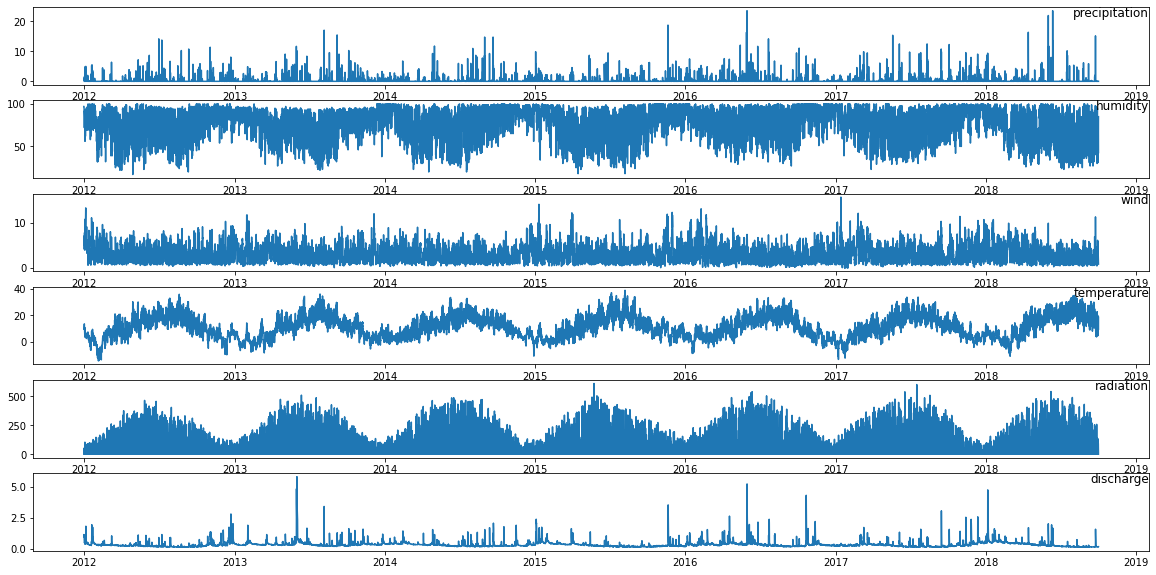

In [4]:
# IMPORT DATASET (USER INPUT)

# File directories of forcing and discharge dataset
path2file_1 = '/content/drive/MyDrive/Master_Thesis/Waldangelbach_Discharge_LSTM/forcing_3h.csv'
path2file_2 = '/content/drive/MyDrive/Master_Thesis/Waldangelbach_Discharge_LSTM/discharge_3h.csv'

#####

# Read data and adjust it
forcing = pd.read_csv(path2file_1)
discharge = pd.read_csv(path2file_2)
forcing.index = pd.to_datetime(forcing['time'], format='%d/%m/%Y %H:%M')
forcing = forcing.drop(['time'],axis=1)
discharge.index = pd.to_datetime(discharge['time'], format='%d/%m/%Y %H:%M')
discharge = discharge.drop(['time'],axis=1)

no_cols = len(forcing.columns)
i = 1
plt.figure(figsize=(20,10))
for column in forcing.columns:
  plt.subplot(no_cols+1,1,i)
  plt.plot(forcing[column])
  plt.title(column,loc='right',y=0.8)
  i+=1
plt.subplot(no_cols+1,1,i)
plt.plot(discharge['discharge'])
plt.title('discharge',loc='right',y=0.8)

Text(1.0, 0.7, 'discharge')

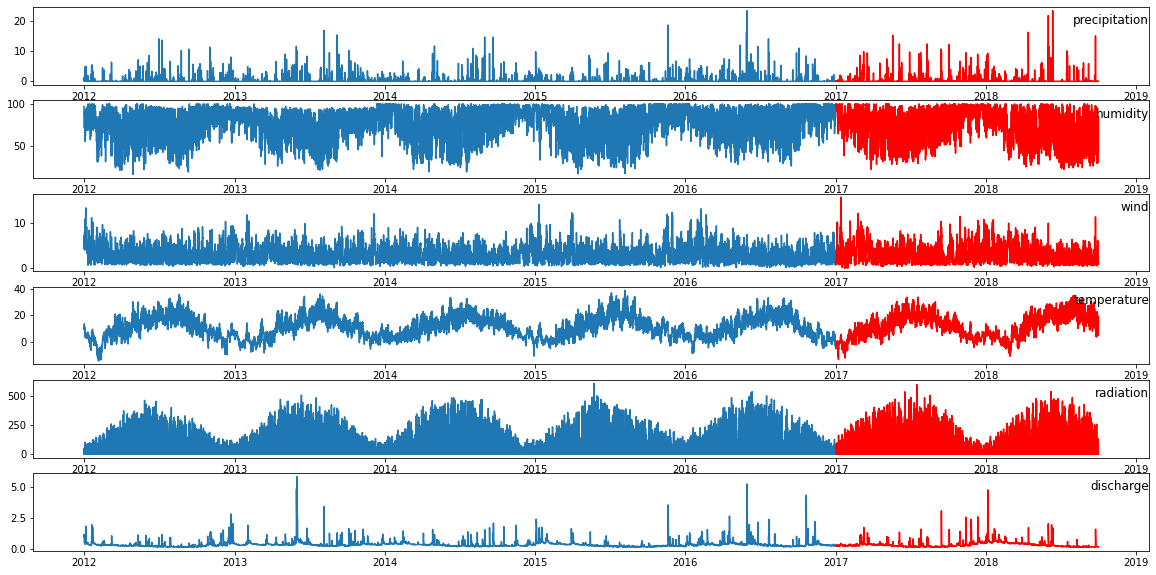

In [5]:
# SEPERATE DATASET INTO TRAINING AND TEST DATA (USER INPUT)

# Seperation point in time between training and test data
split_date = datetime(2017,1,1)

#####

def split_dataset(input, target, split_date):

  train_input = input.loc[input.index < split_date]
  test_input = input.loc[input.index >= split_date]
  train_target = target.loc[target.index < split_date]
  test_target = target.loc[target.index >= split_date]
  train_time = train_input.index
  test_time = test_input.index

  return train_input, train_target, test_input, test_target, train_time, test_time

train_forcing, train_discharge, test_forcing, test_discharge, train_time, test_time = split_dataset(forcing,discharge,split_date)

i = 1
plt.figure(figsize=(20,10))
for column in train_forcing.columns:
  plt.subplot(no_cols+1,1,i)
  plt.plot(train_forcing[column])
  plt.plot(test_forcing[column],'r')
  plt.title(column,loc='right',y=0.7)
  i+=1

plt.subplot(no_cols+1,1,i)
plt.plot(train_discharge['discharge'])
plt.plot(test_discharge['discharge'],'r')
plt.title('discharge',loc='right',y=0.7)

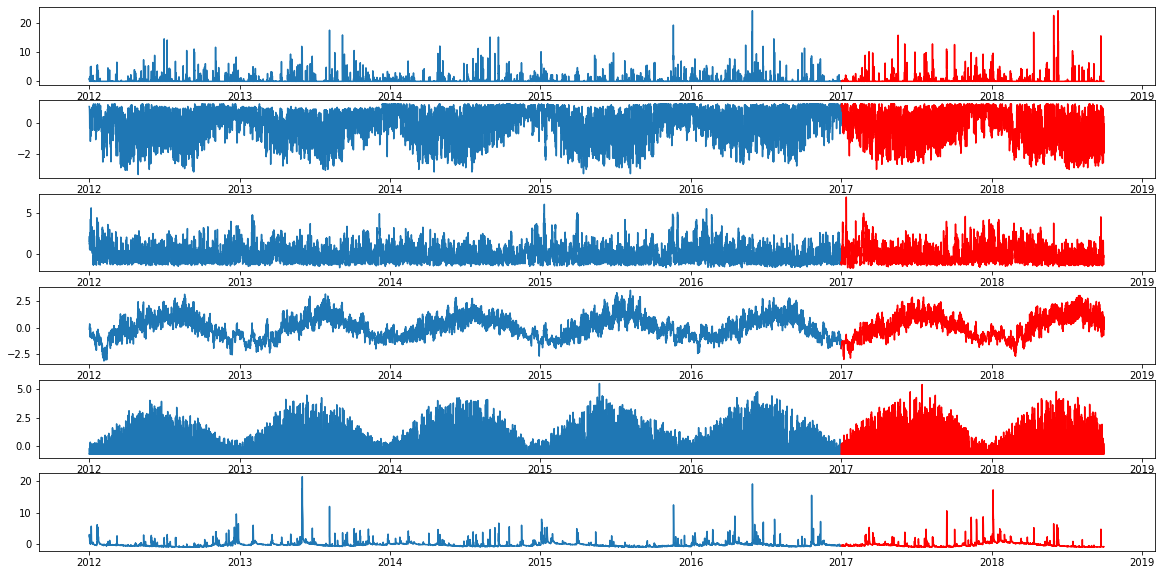

In [6]:
# SCALING (USER INPUT)

# Select scaling options: StandardScaler(), MinMaxScaler(), MinMaxScaler(feature_range(xi,xf)), etc
scaler_forcing = StandardScaler()
scaler_discharge = StandardScaler()

#####

scaler_forcing = scaler_forcing.fit(train_forcing)
scaler_discharge = scaler_discharge.fit(train_discharge)

train_forcing = scaler_forcing.transform(train_forcing)
test_forcing = scaler_forcing.transform(test_forcing)
train_discharge = scaler_discharge.transform(train_discharge)
test_discharge = scaler_discharge.transform(test_discharge)

i = 1
plt.figure(figsize=(20,10))
for column in range(len(train_forcing[0])):
  plt.subplot(no_cols+1,1,i)
  plt.plot(train_time,train_forcing[:,column])
  plt.plot(test_time,test_forcing[:,column],'r')
  i+=1

plt.subplot(no_cols+1,1,i)
plt.plot(train_time,train_discharge)
plt.plot(test_time,test_discharge,'r')

In [7]:
# GENERATE SAMPLES TO USE IN LSTM NETWORK (USER INPUT)

# Select how many data should be used in one sample from the past to predict the value at time 't' 
window_size = 8*365 # number of data in one sample of training data

#####

def generate_samples(input, target, window_size):

  X = []
  y = []

  for i in range(len(input)-window_size-1):
    row = [[a] for a in input[i:i+window_size,0:]]
    X.append(row)
    label = [[a] for a in target[i+window_size+1,0:]]
    y.append(label)
  return np.array(X), np.array(y)

X_train, y_train = generate_samples(train_forcing, train_discharge, window_size)
X_test, y_test = generate_samples(test_forcing, test_discharge, window_size)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[3])

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [58]:
# MODEL ARCHITECTURE (USER INPUT)

model_savepath = 'model/'
tensor_savepath = 'log/'
model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(20, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(20))

model.compile(optimizer='adam', loss='mse')
model.summary()

cp = ModelCheckpoint(model_savepath, save_best_only=True)
cp2 = TensorBoard(log_dir=tensor_savepath)
cp3 = EarlyStopping(patience=3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2920, 20)          2080      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
Total params: 5,780
Trainable params: 5,780
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 0.8590

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 57s 684ms/step - loss: 0.8590 - val_loss: 1.2567
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 0.6775

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 49s 660ms/step - loss: 0.6775 - val_loss: 1.0937
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.5787

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 675ms/step - loss: 0.5787 - val_loss: 0.9091
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.4991

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 677ms/step - loss: 0.4991 - val_loss: 0.8281
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.4455

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 49s 660ms/step - loss: 0.4455 - val_loss: 0.8005
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.4059

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 48s 654ms/step - loss: 0.4059 - val_loss: 0.7516
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.3899

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 682ms/step - loss: 0.3899 - val_loss: 0.6953
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.3541

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 678ms/step - loss: 0.3541 - val_loss: 0.6782
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.3308

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 678ms/step - loss: 0.3308 - val_loss: 0.6315
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.3107

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 680ms/step - loss: 0.3107 - val_loss: 0.5958
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.2854

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 677ms/step - loss: 0.2854 - val_loss: 0.5774
Epoch 12/50
74/74 [==============================] - 40s 544ms/step - loss: 0.2805 - val_loss: 0.5858
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.2548

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 48s 657ms/step - loss: 0.2548 - val_loss: 0.5593
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.2476

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 50s 679ms/step - loss: 0.2476 - val_loss: 0.5049
Epoch 15/50
74/74 [==============================] - 39s 530ms/step - loss: 0.2298 - val_loss: 0.5719
Epoch 16/50
74/74 [==============================] - 40s 543ms/step - loss: 0.2227 - val_loss: 0.5418
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.2115

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


74/74 [==============================] - 49s 662ms/step - loss: 0.2115 - val_loss: 0.4713
Epoch 18/50
74/74 [==============================] - 40s 544ms/step - loss: 0.2063 - val_loss: 0.5690
Epoch 19/50
74/74 [==============================] - 40s 543ms/step - loss: 0.2120 - val_loss: 0.4713
Epoch 20/50
74/74 [==============================] - 40s 544ms/step - loss: 0.1930 - val_loss: 0.4765


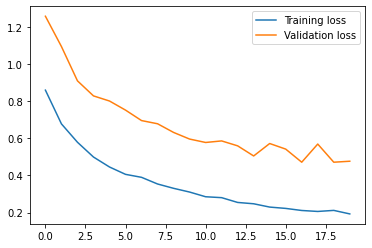

In [59]:
# MODEL TRAINING (NO USER INPUT)

model_training = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[cp,cp2,cp3])

plt.plot(model_training.history['loss'], label='Training loss')
plt.plot(model_training.history['val_loss'], label='Validation loss')
plt.legend()

In [131]:
# IMPORT MODEL AND PREDICT TRAINING AND TEST DATA (NO USER INPUT)

model = load_model(model_savepath)
train_predictions = model.predict(X_train).mean(axis=1)
test_predictions = model.predict(X_test).mean(axis=1)

train_predictions = scaler_discharge.inverse_transform(train_predictions.reshape(train_predictions.shape[0],1))
test_predictions = scaler_discharge.inverse_transform(test_predictions.reshape(test_predictions.shape[0],1))
y_train = scaler_discharge.inverse_transform(y_train.reshape(y_train.shape[0],y_train.shape[1]))
y_test = scaler_discharge.inverse_transform(y_test.reshape(y_test.shape[0],y_test.shape[1]))


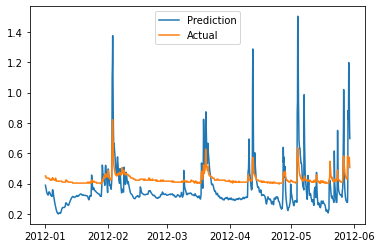

In [132]:
# VISUALISATION TRAINING DATA (USER INPUT)

plt.plot(train_time[0:1200],train_predictions[0:1200,0],label = 'Prediction')
plt.plot(train_time[0:1200],y_train[0:1200,0],label = 'Actual')
plt.legend()

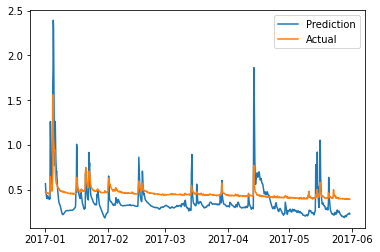

In [133]:
# VISUALISATION TEST DATA (USER INPUT)
plt.plot(test_time[0:1200],test_predictions[0:1200,0],label = 'Prediction')
plt.plot(test_time[0:1200],y_test[0:1200,0],label = 'Actual')
plt.legend()

In [123]:
# PERFORMANCE METRICS (NO USER INPUT)

error_table = np.zeros((3,2))
# NSE
def nse(target, prediction):
  return (1-(np.sum(np.square(target-prediction))/np.sum(np.square(target-np.mean(target)))))

# RMSE
def rmse(target,prediction):
  return (np.sqrt(( np.square(target-prediction) ).mean()))

# MAE
def mae(target,prediction):
  return (abs(target-prediction).mean())

error_table[0,0] = nse(y_train,train_predictions)
error_table[1,0] = rmse(y_train,train_predictions)
error_table[2,0] = mae(y_train,train_predictions)
error_table[0,1] = nse(y_test,test_predictions)
error_table[1,1] = rmse(y_test,test_predictions)
error_table[2,1] = mae(y_test,test_predictions)

error_table = pd.DataFrame(error_table,columns=['Training','Test'],index=['NSE','RMSE','MAE'])
error_table

,Training,Test
NSE,0.762298,0.481119
RMSE,0.128960,0.198080
MAE,0.063872,0.122020


In [128]:
# SAVE DATASETS

pd.DataFrame(np.hstack((y_train,train_predictions)),index=train_time[window_size+1:],columns=['y_train','train_predictions']).to_csv('model_train.csv')
pd.DataFrame(np.hstack((y_test,test_predictions)),index=test_time[window_size+1:],columns=['y_test','test_predictions']).to_csv('model_test.csv')
pd.DataFrame.from_dict(model_training.history).to_csv('model_loss.csv')
error_table.to_csv('model_error.csv')
!zip -r model.zip model/ 

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 90%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 64%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 13%)


In [129]:
!unzip model1.zip

Archive:  model1.zip
   creating: model1/
   creating: model1/assets/
  inflating: model1/keras_metadata.pb  
  inflating: model1/saved_model.pb   
   creating: model1/variables/
  inflating: model1/variables/variables.data-00000-of-00001  
  inflating: model1/variables/variables.index  
